In [100]:
import pandas as pd

df = pd.read_csv("data/out/model_ready_min.csv")
df.head() 

,county_fips,year,y_growth_next_winz,unemp_asof,unemp_lag1,unemp_chg_1y,unemp_ma3,unemp_missing_t,pov_asof,pov_lag1,pov_chg_1y,pov_ma3,pov_missing_t,log_hpi_t,hpi_growth_1y
0,1001,2001,0.021791,4.1,NaN,NaN,4.100000,0,10.8,NaN,NaN,10.800000,0,11.763441,NaN
1,1001,2002,0.027732,4.8,4.1,0.7,4.450000,0,10.3,10.8,-0.5,10.550000,0,11.785232,0.021791
2,1001,2003,0.052465,5.0,4.8,0.2,4.633333,0,10.4,10.3,0.1,10.500000,0,11.812965,0.027732
3,1001,2004,0.073513,4.7,5.0,-0.3,4.833333,0,11.6,10.4,1.2,10.766667,0,11.865430,0.052465
4,1001,2005,0.065710,3.8,4.7,-0.9,4.500000,0,10.4,11.6,-1.2,10.800000,0,11.938942,0.073513


In [101]:
# pick the target that exists
target = "y_growth_next_winz" if "y_growth_next_winz" in df.columns else "y_growth_next"

# drop rows where target  missing
train = df.dropna(subset=[target]).reset_index(drop=True)

# (alt) same result:
# train = df[df[target].notna()].reset_index(drop=True)

train.head()

,county_fips,year,y_growth_next_winz,unemp_asof,unemp_lag1,unemp_chg_1y,unemp_ma3,unemp_missing_t,pov_asof,pov_lag1,pov_chg_1y,pov_ma3,pov_missing_t,log_hpi_t,hpi_growth_1y
0,1001,2001,0.021791,4.1,NaN,NaN,4.100000,0,10.8,NaN,NaN,10.800000,0,11.763441,NaN
1,1001,2002,0.027732,4.8,4.1,0.7,4.450000,0,10.3,10.8,-0.5,10.550000,0,11.785232,0.021791
2,1001,2003,0.052465,5.0,4.8,0.2,4.633333,0,10.4,10.3,0.1,10.500000,0,11.812965,0.027732
3,1001,2004,0.073513,4.7,5.0,-0.3,4.833333,0,11.6,10.4,1.2,10.766667,0,11.865430,0.052465
4,1001,2005,0.065710,3.8,4.7,-0.9,4.500000,0,10.4,11.6,-1.2,10.800000,0,11.938942,0.073513


In [102]:
# 1) Imports
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error



In [103]:
#  metrics helper (no FutureWarning) 
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def RMSE(y_true, y_pred): return float(_rmse(y_true, y_pred))
except Exception:
    def RMSE(y_true, y_pred): return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# ---------- 0) Feature engineering (NO LOOK-AHEAD) ----------
def detect_level_col(df, candidates=("zhvi","hpi","level")):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def engineer_features_no_leak(df: pd.DataFrame,
                              target_col: str = "y_growth_next_winz",
                              county_col: str = "county_fips",
                              year_col: str = "year") -> pd.DataFrame:
    """
    Adds backward-looking features that won't leak future info:
      log_level, log_level_lag1
      y_growth_prev (last year's growth), growth_ma2, growth_ma3 (momentum)
      For numeric drivers (excluding keys/target), 1y delta: col_chg_1y = col - col_lag1
    Implementation avoids index-mismatch by resetting the groupby-rolling index.
    """
    df = df.sort_values([county_col, year_col]).copy()

    # Level features
    lvl = detect_level_col(df)
    if lvl is not None:
        df["log_level"] = np.log(df[lvl].replace({0: np.nan}))
        df["log_level_lag1"] = df.groupby(county_col)["log_level"].shift(1)

    # Target persistence + momentum (no leakage)
    if target_col in df.columns:
        df["y_growth_prev"] = df.groupby(county_col)[target_col].shift(1)

        gprev = df.groupby(county_col)["y_growth_prev"]
        df["growth_ma2"] = (
            gprev.rolling(window=2, min_periods=1)
                 .mean()
                 .reset_index(level=0, drop=True)
        )
        df["growth_ma3"] = (
            gprev.rolling(window=3, min_periods=1)
                 .mean()
                 .reset_index(level=0, drop=True)
        )

    # Driver deltas (1y changes) for numeric columns
    keyset = {county_col, year_col, target_col, "log_level", "log_level_lag1",
              "y_growth_prev", "growth_ma2", "growth_ma3"}
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    driver_candidates = [c for c in num_cols if c not in keyset]

    # Compute change safely (aligned indices)
    for col in driver_candidates:
        lag1 = df.groupby(county_col)[col].shift(1)
        df[f"{col}_chg_1y"] = df[col] - lag1

    return df


In [104]:
#  1) No-look-ahead imputer (no groupby.apply deprecation)
class TimeAwareCountyImputer(BaseEstimator, TransformerMixin):
    """
     *_chg_1y, *_growth_1y -> fillna(0)
     *_lag*, *_ma3 -> forward-fill per county; optionally bfill ONLY on first year of that county
    Keeps row order. Needs 'county_fips' and 'year'.
    """
    def __init__(self, county_col="county_fips", year_col="year", bfill_first_year_only=True):
        self.county_col = county_col
        self.year_col = year_col
        self.bfill_first_year_only = bfill_first_year_only

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("TimeAwareCountyImputer expects a pandas DataFrame.")
        keys = {self.county_col, self.year_col}
        self.feature_cols_ = [c for c in X.columns if c not in keys]
        self.growth_cols_  = [c for c in self.feature_cols_ if c.endswith("_chg_1y") or c.endswith("_growth_1y")]
        self.ffill_cols_   = [c for c in self.feature_cols_ if ("_lag" in c) or c.endswith("_ma3")]
        return self

    def transform(self, X):
        X = X.copy()

        # Structural first-year missingness -> 0
        if self.growth_cols_:
            present = [c for c in self.growth_cols_ if c in X.columns]
            if present:
                X[present] = X[present].fillna(0)

        # Forward-fill lag/MA per county
        if self.ffill_cols_:
            present = [c for c in self.ffill_cols_ if c in X.columns]
            if present:
                X[present] = X.groupby(self.county_col, group_keys=False)[present].ffill()

                # Optionally bfill ONLY on each county's first year
                if self.bfill_first_year_only:
                    first_year = X.groupby(self.county_col)[self.year_col].transform("min")
                    mask = X[self.year_col].eq(first_year)
                    bfilled = X.groupby(self.county_col, group_keys=False)[present].bfill()
                    X.loc[mask, present] = bfilled.loc[mask, present]
                else:
                    X[present] = X.groupby(self.county_col, group_keys=False)[present].bfill()

        # Final safety: ffill all features per county (no bfill)
        if self.feature_cols_:
            pres = [c for c in self.feature_cols_ if c in X.columns]
            if pres:
                X[pres] = X.groupby(self.county_col, group_keys=False)[pres].ffill()

        return X

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols): self.cols = list(cols)
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        to_drop = [c for c in self.cols if c in X.columns]
        # also drop any accidental metadata columns (e.g., "__source__")
        to_drop.extend([c for c in X.columns if c.startswith("__")])
        to_drop = sorted(set(to_drop))
        return X.drop(columns=to_drop, errors="ignore")

class AlignColumns(BaseEstimator, TransformerMixin):
    """
    Remember training feature columns; at transform:
      drop unknown columns
      add missing ones as NaN
      enforce training-time column order
    """
    def fit(self, X, y=None):
        self.cols_ = list(X.columns)
        return self
    def transform(self, X):
        X = X.copy()
        for c in self.cols_:
            if c not in X.columns:
                X[c] = np.nan
        return X[self.cols_]


In [105]:
# 2. Models 
ridge_pipe = Pipeline([
    ("imputer", TimeAwareCountyImputer()),
    ("dropper", DropColumns(["county_fips", "year"])),
    ("align",  AlignColumns()),
    ("nanfix", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

rf_pipe = Pipeline([
    ("imputer", TimeAwareCountyImputer()),
    ("dropper", DropColumns(["county_fips", "year"])),
    ("align",  AlignColumns()),
    ("nanfix", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, min_samples_leaf=2))
])

hgb_pipe = Pipeline([
    ("imputer", TimeAwareCountyImputer()),
    ("dropper", DropColumns(["county_fips", "year"])),
    ("align",  AlignColumns()),
    ("nanfix", SimpleImputer(strategy="median")),  # HGB can handle NaN but this keeps things stable
    ("model", HistGradientBoostingRegressor(random_state=42,
                                            learning_rate=0.07,
                                            max_leaf_nodes=31,
                                            max_depth=None,
                                            l2_regularization=0.0,
                                            early_stopping=True))
])

HGB_GRID = [
    dict(learning_rate=[0.03, 0.07], max_leaf_nodes=[31, 63], max_depth=[None, 6], l2_regularization=[0.0, 0.1]),
    dict(learning_rate=[0.1], max_leaf_nodes=[31], max_depth=[None], l2_regularization=[0.0, 0.1]),
]


In [106]:
# 3. CV +  model selection 
def time_cv_score(df, target_col, pipe, n_splits=5):
    df_sorted = df.sort_values(["year","county_fips"]).reset_index(drop=True)
    X = df_sorted.drop(columns=[target_col])
    y = df_sorted[target_col].to_numpy()

    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses, r2s, mapes = [], [], []
    for tr_idx, te_idx in tscv.split(X):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y[tr_idx],      y[te_idx]
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)
        rmses.append(RMSE(y_te, y_pred))
        r2s.append(r2_score(y_te, y_pred))
        mapes.append(mean_absolute_percentage_error(np.where(y_te == 0, 1e-9, y_te), y_pred))
    return {"RMSE": float(np.mean(rmses)), "R2": float(np.mean(r2s)), "MAPE": float(np.mean(mapes))}

def select_and_fit_best_with_baseline(df, target_col="y_growth_next_winz", n_splits=5):
    """
    Extended model selection that includes:
      - Ridge
      - RandomForest
      - XGBoost
      - Naive baseline (last year's growth)
    Returns the best pipeline and a report dict.
    """
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import Ridge
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
    import numpy as np
    from xgboost import XGBRegressor
    from sklearn.model_selection import TimeSeriesSplit

    # Setup
    X = df.drop(columns=[target_col])
    y = df[target_col]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = {}

    # Baseline (naive lag)
    if "y_growth_prev" in df.columns:
        y_naive = df["y_growth_prev"]
        mask = y_naive.notna()
        baseline_rmse = mean_squared_error(y[mask], y_naive[mask], squared=False)
        baseline_r2 = r2_score(y[mask], y_naive[mask])
        baseline_mape = mean_absolute_percentage_error(y[mask], y_naive[mask])
        results["naive"] = {"RMSE": baseline_rmse, "R2": baseline_r2, "MAPE": baseline_mape}

    # Ridge
    ridge_pipe = Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ])
    ridge_rmse, ridge_r2, ridge_mape = [], [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        ridge_pipe.fit(X_train, y_train)
        y_pred = ridge_pipe.predict(X_test)
        ridge_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        ridge_r2.append(r2_score(y_test, y_pred))
        ridge_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    results["ridge"] = {"RMSE": np.mean(ridge_rmse), "R2": np.mean(ridge_r2), "MAPE": np.mean(ridge_mape)}
    
    # Random Forest
    rf_pipe = Pipeline([
        ("imputer", SimpleImputer()),
        ("model", RandomForestRegressor(n_estimators=200, random_state=42))
    ])
    rf_rmse, rf_r2, rf_mape = [], [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        rf_pipe.fit(X_train, y_train)
        y_pred = rf_pipe.predict(X_test)
        rf_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        rf_r2.append(r2_score(y_test, y_pred))
        rf_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    results["rf"] = {"RMSE": np.mean(rf_rmse), "R2": np.mean(rf_r2), "MAPE": np.mean(rf_mape)}
    
    # XGBoost
    xgb_pipe = Pipeline([
        ("imputer", SimpleImputer()),
        ("model", XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=4,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1))
    ])
    xgb_rmse, xgb_r2, xgb_mape = [], [], []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        xgb_pipe.fit(X_train, y_train)
        y_pred = xgb_pipe.predict(X_test)
        xgb_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        xgb_r2.append(r2_score(y_test, y_pred))
        xgb_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    results["xgb"] = {"RMSE": np.mean(xgb_rmse), "R2": np.mean(xgb_r2), "MAPE": np.mean(xgb_mape)}
    
    # Choose best model (highest R2)
    best_name = max(results, key=lambda k: results[k]["R2"])
    best_pipe = {"ridge": ridge_pipe, "rf": rf_pipe, "xgb": xgb_pipe}.get(best_name, None)
    
    return best_pipe, {"report": results, "chosen": best_name}


In [107]:
#  4. Forecast helpers 
def _numeric_feature_cols(df: pd.DataFrame, target_col: str, key_cols=("county_fips", "year")):
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in nums if c not in set(key_cols) | {target_col}]

def _project_drivers_hold(prev_year_df: pd.DataFrame, driver_cols: list[str]) -> pd.DataFrame:
    return prev_year_df[driver_cols].copy()

def _project_drivers_ar1(history: pd.DataFrame, prev_year_df: pd.DataFrame, driver_cols: list[str]) -> pd.DataFrame:
    out = prev_year_df[driver_cols].copy()
    for fips, g_prev in prev_year_df.groupby("county_fips"):
        g_hist = history[history["county_fips"] == fips].sort_values("year")
        for col in driver_cols:
            s = g_hist[col].dropna().to_numpy()
            if s.size >= 4:
                X = s[:-1].reshape(-1, 1); y = s[1:]
                try:
                    lr = LinearRegression().fit(X, y)
                    pred = float(lr.predict(s[-1:].reshape(-1, 1))[0])
                except Exception:
                    pred = float(s[-1])
            else:
                pred = float(s[-1]) if s.size else np.nan
            out.loc[g_prev.index, col] = pred
    for col in driver_cols:
        na = out[col].isna()
        if na.any():
            out.loc[na, col] = prev_year_df.loc[na, col].values
    return out

def _roll_lags_from_prev(prev_year_df: pd.DataFrame, candidate_cols: list[str]) -> pd.DataFrame:
    out = prev_year_df[candidate_cols].copy()
    for c in candidate_cols:
        if c.endswith("_lag1"):
            base = c[:-5]
            if base in prev_year_df.columns:
                out[c] = prev_year_df[base].values
    return out

def _make_pseudo_next_year(full_hist: pd.DataFrame,
                           prev_year_df: pd.DataFrame,
                           next_year: int,
                           feature_cols: list[str],
                           driver_strategy: str = "hold",
                           driver_cols: list[str] | None = None) -> pd.DataFrame:
    """
    Build a pseudo next-year frame from prev_year_df.
    - Lags: roll from prev_year_df
    - Drivers: either hold-constant or AR(1) using HISTORY (full_hist)
    """
    pseudo = prev_year_df.copy()
    pseudo["year"] = next_year

    lag_like = [c for c in feature_cols if c.endswith("_lag1")]
    if driver_cols is None:
        driver_cols = [c for c in feature_cols if c not in lag_like]

    # Roll *_lag1 from base columns; carry other cols
    rolled = _roll_lags_from_prev(prev_year_df, feature_cols)

    # pass 'history=' instead of 'full_hist'
    if driver_strategy == "ar1":
        drivers_next = _project_drivers_ar1(history=full_hist,
                                            prev_year_df=prev_year_df,
                                            driver_cols=driver_cols)
    else:
        drivers_next = _project_drivers_hold(prev_year_df, driver_cols)

    X_next = rolled.copy()
    for col in driver_cols:
        X_next[col] = drivers_next[col].values

    for col in feature_cols:
        if col in X_next.columns:
            pseudo[col] = X_next[col].values

    return pseudo


def _update_level(prev_year_df: pd.DataFrame,
                  pred_growth: np.ndarray,
                  level_col: str | None,
                  growth_is_fraction: bool = True) -> pd.DataFrame:
    out = prev_year_df.copy()
    out["pred_growth"] = pred_growth
    if level_col is not None and level_col in prev_year_df.columns:
        out[level_col] = prev_year_df[level_col].values * (1.0 + pred_growth)
    return out

In [108]:
# 5. Public forecast APIs 
def dummy_predict_2024(best_pipe,
                       df: pd.DataFrame,
                       target_col: str = "y_growth_next_winz",
                       base_year: int = 2023,
                       driver_strategy: str = "hold",
                       explicit_driver_cols: list[str] | None = None,
                       growth_is_fraction: bool = True):
    df_sorted = df.sort_values(["year","county_fips"]).reset_index(drop=True)
    feature_cols = _numeric_feature_cols(df_sorted, target_col=target_col)
    level_col = detect_level_col(df_sorted)

    base_2023 = df_sorted[df_sorted["year"] == base_year].copy()
    if base_2023.empty:
        raise ValueError(f"No rows found for base_year={base_year}.")

    if explicit_driver_cols is not None:
        driver_cols = [c for c in explicit_driver_cols if c in feature_cols]
    else:
        driver_cols = [c for c in feature_cols if not c.endswith("_lag1")]

    pseudo_2024 = _make_pseudo_next_year(
        full_hist=df_sorted, prev_year_df=base_2023, next_year=base_year + 1,
        feature_cols=feature_cols, driver_strategy=driver_strategy, driver_cols=driver_cols
    )
    X_2024 = pseudo_2024.drop(columns=[target_col], errors="ignore")
    X_2024 = _align_cols(X_2024, best_pipe)
    pred_growth_2024 = best_pipe.predict(X_2024)

    pred_2024 = _update_level(base_2023, pred_growth_2024, level_col, growth_is_fraction=growth_is_fraction)
    pred_2024["year"] = base_year + 1

    keep = ["county_fips","year","pred_growth"]
    if level_col: keep.append(level_col)
    pred_2024 = pred_2024[keep].sort_values(["county_fips","year"]).reset_index(drop=True)

    metrics = {}
    if target_col in base_2023.columns:
        y_true_growth = base_2023[target_col].to_numpy()
        metrics["growth_2024_vs_true"] = {
            "MAE": float(mean_absolute_error(y_true_growth, pred_growth_2024)),
            "RMSE": RMSE(y_true_growth, pred_growth_2024),
            "R2": float(r2_score(y_true_growth, pred_growth_2024)),
            "MAPE": float(mean_absolute_percentage_error(np.where(y_true_growth==0, 1e-9, y_true_growth), pred_growth_2024)),
        }

    if level_col:
        actual_2024 = df_sorted[df_sorted["year"] == base_year + 1]
        if not actual_2024.empty:
            m = pred_2024.merge(actual_2024[["county_fips", level_col]], on="county_fips", how="inner",
                                suffixes=("_pred","_act"))
            if not m.empty:
                yt = m[f"{level_col}_act"].to_numpy()
                yp = m[f"{level_col}_pred"].to_numpy()
                metrics["level_2024_vs_true"] = {
                    "MAE": float(mean_absolute_error(yt, yp)),
                    "RMSE": RMSE(yt, yp),
                    "R2": float(r2_score(yt, yp)),
                    "MAPE": float(mean_absolute_percentage_error(np.where(yt==0, 1e-9, yt), yp)),
                }
    return pred_2024, metrics

def recursive_predict_2025_2026(best_pipe,
                                df: pd.DataFrame,
                                target_col: str = "y_growth_next_winz",
                                base_year: int = 2024,
                                driver_strategy: str = "hold",
                                explicit_driver_cols: list[str] | None = None,
                                growth_is_fraction: bool = True):
    df_sorted = df.sort_values(["year", "county_fips"]).reset_index(drop=True)
    feature_cols = _numeric_feature_cols(df_sorted, target_col=target_col)
    level_col = detect_level_col(df_sorted)

    base_2024 = df_sorted[df_sorted["year"] == base_year].copy()
    if base_2024.empty:
        raise ValueError(f"No rows found for base_year={base_year} (need 2024 base).")

    if explicit_driver_cols is not None:
        driver_cols = [c for c in explicit_driver_cols if c in feature_cols]
    else:
        driver_cols = [c for c in feature_cols if not c.endswith("_lag1")]

    # 2025
    pseudo_2025 = _make_pseudo_next_year(
        full_hist=df_sorted, prev_year_df=base_2024, next_year=base_year + 1,
        feature_cols=feature_cols, driver_strategy=driver_strategy, driver_cols=driver_cols
    )
    X_2025 = pseudo_2025.drop(columns=[target_col], errors="ignore")
    X_2025 = _align_cols(X_2025, best_pipe)
    pred_g_2025 = best_pipe.predict(X_2025)
    pred_2025 = _update_level(base_2024, pred_g_2025, level_col, growth_is_fraction=growth_is_fraction)
    pred_2025["year"] = base_year + 1

    # 2026
    pseudo_2026 = _make_pseudo_next_year(
        full_hist=df_sorted, prev_year_df=pred_2025, next_year=base_year + 2,
        feature_cols=feature_cols, driver_strategy=driver_strategy, driver_cols=driver_cols
    )
    X_2026 = pseudo_2026.drop(columns=[target_col], errors="ignore")
    X_2026 = _align_cols(X_2026, best_pipe)
    pred_g_2026 = best_pipe.predict(X_2026)
    pred_2026 = _update_level(pred_2025, pred_g_2026, level_col, growth_is_fraction=growth_is_fraction)
    pred_2026["year"] = base_year + 2

    keep = ["county_fips","year","pred_growth"]
    if level_col: keep.append(level_col)
    pred_2025 = pred_2025[keep].sort_values(["county_fips","year"]).reset_index(drop=True)
    pred_2026 = pred_2026[keep].sort_values(["county_fips","year"]).reset_index(drop=True)
    return pred_2025, pred_2026

def _align_cols(X_new, pipe):
    """Align prediction dataframe with training schema"""
    return X_new.reindex(columns=pipe.feature_names_in_, fill_value=np.nan)


In [111]:
# 6. End-to-end usage 
# 6.1 Keep master with ALL years
df_all = df.copy().sort_values(["county_fips","year"]).reset_index(drop=True)

# 6.2 Create next-year growth target if missing (change 'zhvi' if needed)
if "y_growth_next_winz" not in df_all.columns:
    lvl = detect_level_col(df_all)
    if lvl is None:
        raise ValueError("No level column found. Add 'zhvi' or 'hpi'.")
    y_next = (df_all.groupby("county_fips")[lvl]
                    .apply(lambda s: s.pct_change().shift(-1))
                    .reset_index(level=0, drop=True))
    df_all["y_growth_next_winz"] = y_next

# 6.3  extra no-leak features
df_all = engineer_features_no_leak(
    df_all, target_col="y_growth_next_winz",
    county_col="county_fips", year_col="year"
)

# 6.4 Modeling set: only rows where target exists (this will drop 2024 here, not in df_all)
df_model = df_all[df_all["y_growth_next_winz"].notna()].copy()

best_pipe, report = select_and_fit_best_with_baseline(
    df_model, target_col="y_growth_next_winz", n_splits=5
)
print(report)

# 6.5 Training feature names 
X_train_cols = df_model.drop(columns=["y_growth_next_winz"]).columns
# Access safely 
_ = getattr(best_pipe, "feature_names_in_", None)
# Optional: stash for your own reference without touching sklearn internals
best_pipe._train_features = list(X_train_cols)

# 6.6 If 2024 missing, synthesize from 2023 (no marker columns)
if not (df_all["year"] == 2024).any():
    print("2024 not found in df_all -> creating dummy 2024 from 2023...")
    pred2024_base, _ = dummy_predict_2024(
        best_pipe, df_all,
        target_col="y_growth_next_winz",
        base_year=2023,
        driver_strategy="hold",
        explicit_driver_cols=None,
        growth_is_fraction=True
    )
    lvl = detect_level_col(df_all)
    cols = ["county_fips","year"] + ([lvl] if lvl else [])
    base_2024_rows = pred2024_base[cols].copy()
    df_all = (pd.concat([df_all, base_2024_rows], ignore_index=True)
                .sort_values(["county_fips","year"])
                .reset_index(drop=True))

# 6.7 Safety: drop any stray metadata columns
df_all = df_all.drop(columns=[c for c in df_all.columns if c.startswith("__")], errors="ignore")

# 6.8 Predictions
pred2024, metrics2024 = dummy_predict_2024(
    best_pipe, df_all,
    target_col="y_growth_next_winz",
    base_year=2023,
    driver_strategy="hold",
    explicit_driver_cols=None,
    growth_is_fraction=True
)

pred2025, pred2026 = recursive_predict_2025_2026(
    best_pipe, df_all,
    target_col="y_growth_next_winz",
    base_year=2024,
    driver_strategy="ar1",   #  "ar1" for driver dynamics
    explicit_driver_cols=None,
    growth_is_fraction=True
)

pred_all = (pd.concat([pred2024, pred2025, pred2026], ignore_index=True)
              .sort_values(["county_fips","year"])
              .reset_index(drop=True))

print("Prediction years:", sorted(pred_all["year"].unique()))
try:
    print("2024 sanity metrics:", metrics2024)
except Exception:
    pass


C:\Users\wesle\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\wesle\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\wesle\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\wesle\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

{'report': {'naive': {'RMSE': 0.06076599546179148, 'R2': 0.0366054633067987, 'MAPE': 4.24006097067924}, 'ridge': {'RMSE': 0.05027322532828811, 'R2': 0.25564080866167316, 'MAPE': 4.516109941970535}, 'rf': {'RMSE': 0.042641886515315475, 'R2': 0.46468220505553937, 'MAPE': 3.7779815982526586}, 'xgb': {'RMSE': 0.041157784749452885, 'R2': 0.5016393754173487, 'MAPE': 4.112198068346504}}, 'chosen': 'xgb'}
2024 not found in df_all -> creating dummy 2024 from 2023...
Prediction years: [2024, 2025, 2026]
2024 sanity metrics: {'growth_2024_vs_true': {'MAE': 0.02188802231555987, 'RMSE': 0.02985272060609193, 'R2': 0.25512502317696306, 'MAPE': 3.2098779539810813}}


In [115]:
!pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 1.3 MB/s eta 0:00:00


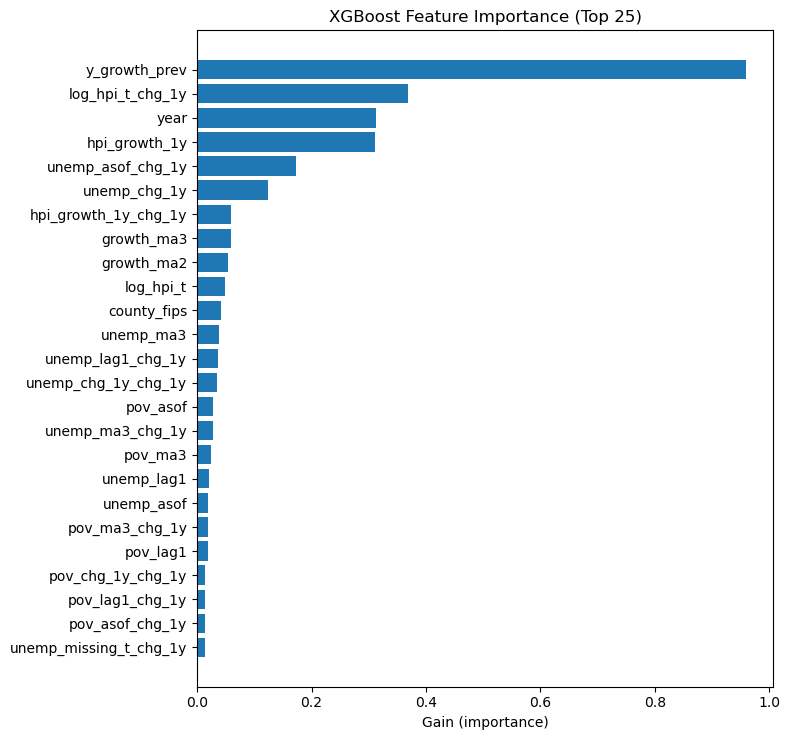

[OK] Saved feature importance CSV/PNG to artifacts/


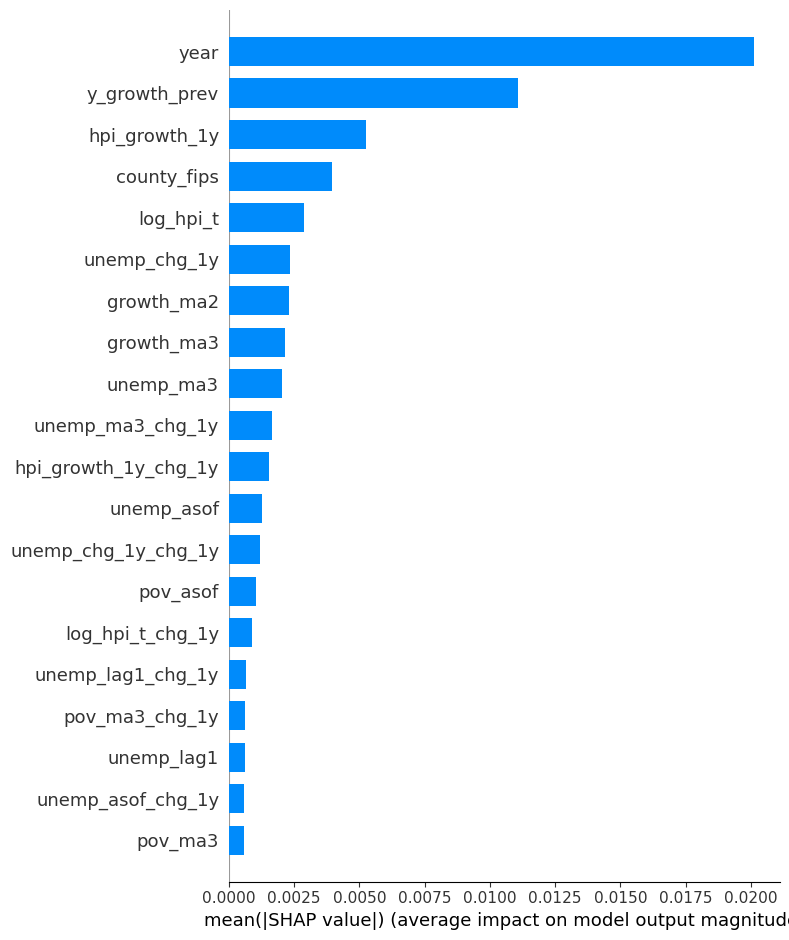

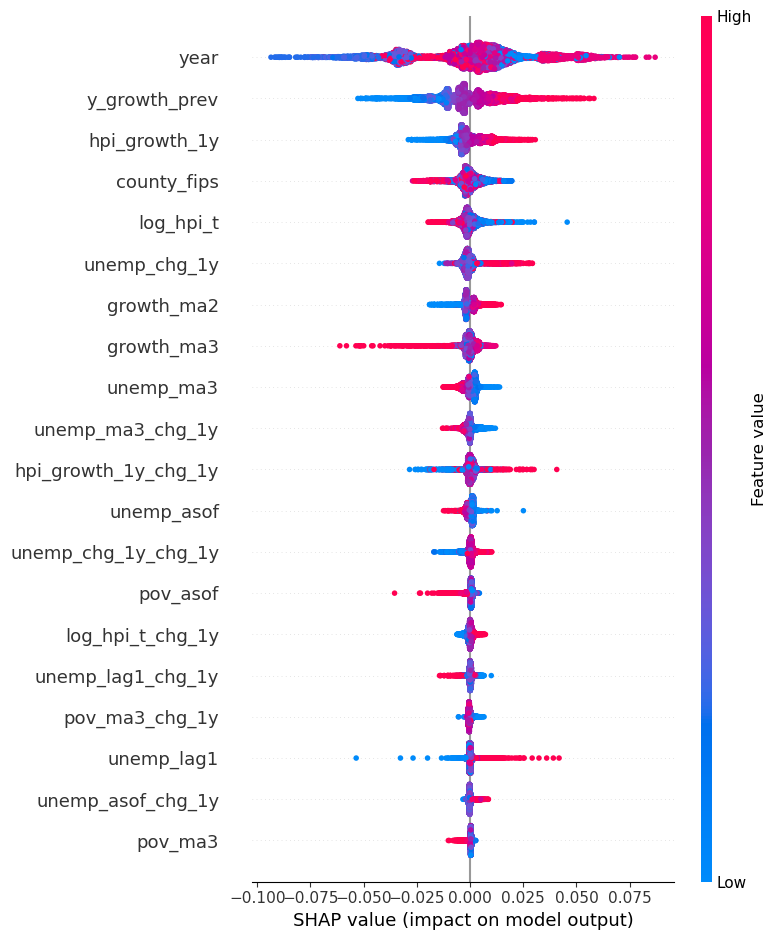

[OK] Saved SHAP plots to artifacts/


In [125]:
# same input columns the model saw at fit time 
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Columns the model was fit on 
try:
    input_cols = list(model.feature_names_in_)   # works for Pipeline and many estimators
except AttributeError:
    # Fallback: if not available, add id/year to feats (your error complained about these)
    base = set(feats)
    base.update([id_col, year_col])
    input_cols = [c for c in df_all_local.columns if c in base]

# Build raw design matrix exactly as at fit time
X_all_raw = df_all_local[input_cols].copy()

# Extract inner XGB + the preprocessor transform callable 
def extract_xgb_and_transformer(m):
    if isinstance(m, XGBRegressor):
        return m, (lambda X: X), list(X.columns)
    if isinstance(m, Pipeline):
        xgb_name = None
        for name, step in m.named_steps.items():
            if isinstance(step, XGBRegressor):
                xgb_name = name
        if xgb_name is None:
            raise ValueError("Pipeline does not contain an XGBRegressor step.")
        step_names = list(m.named_steps.keys())
        last_idx = step_names.index(xgb_name)
        preproc = (lambda X: X) if last_idx == 0 else m[:last_idx].transform

        feat_names = None
        try:
            pre = m[:last_idx]
            if hasattr(pre, "get_feature_names_out"):
                feat_names = list(pre.get_feature_names_out())
        except Exception:
            pass
        return m.named_steps[xgb_name], preproc, feat_names
    raise ValueError("Unsupported model type; expected XGBRegressor or Pipeline.")

tmp = extract_xgb_and_transformer(model)
if len(tmp) == 3:
    xgb_est, transform_X, feat_names = tmp
else:
    xgb_est, transform_X = tmp
    feat_names = None

# Transform with the pipeline preprocessor to get model-ready features
X_model = transform_X(X_all_raw)

# Feature importance (gain) with robust name mapping
try:
    booster = xgb_est.get_booster()
    score_map = booster.get_score(importance_type="gain")
    if not score_map:
        raise ValueError("Empty gain map; fallback to .feature_importances_.")
    import pandas as pd
    imp = pd.DataFrame([(k, v) for k, v in score_map.items()],
                       columns=["feature_alias", "gain"])

    def alias_to_name(a):
        if a.startswith("f") and a[1:].isdigit():
            idx = int(a[1:])
            if feat_names is not None and 0 <= idx < len(feat_names):
                return feat_names[idx]
        return a

    imp["feature"] = imp["feature_alias"].map(alias_to_name)
    imp = imp.groupby("feature", as_index=False)["gain"].sum().sort_values("gain", ascending=False)
except Exception:
    vals = getattr(xgb_est, "feature_importances_", None)
    if vals is None:
        raise
    cols = feat_names if (feat_names is not None and len(feat_names) == len(vals)) else [f"f{i}" for i in range(len(vals))]
    imp = pd.DataFrame({"feature": cols, "gain": vals}).sort_values("gain", ascending=False)

imp.to_csv(os.path.join(ARTIFACT_DIR, "feature_importance_full.csv"), index=False)

topN = 25
imp_top = imp.head(topN)
plt.figure(figsize=(8, max(4, 0.3*len(imp_top))))
plt.barh(imp_top["feature"][::-1], imp_top["gain"][::-1])
plt.title(f"XGBoost Feature Importance (Top {topN})")
plt.xlabel("Gain (importance)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "feature_importance_topN.png"), dpi=160)
plt.show()
print("[OK] Saved feature importance CSV/PNG to artifacts/")

#  SHAP on model-ready features 
import shap
explainer = shap.TreeExplainer(xgb_est)

# Sample for speed
if hasattr(X_model, "shape"):
    sample_n = min(10000, X_model.shape[0])
    if isinstance(X_model, np.ndarray):
        rng = np.random.RandomState(42)
        idx = rng.choice(X_model.shape[0], sample_n, replace=False)
        X_sample = X_model[idx, :]
    else:
        X_sample = X_model if X_model.shape[0] <= sample_n else X_model.sample(sample_n, random_state=42)
else:
    X_sample = X_model

sv = explainer(X_sample)

plt.figure(figsize=(8,5))
shap.summary_plot(sv, X_sample, plot_type="bar", show=False, feature_names=feat_names if feat_names is not None else None)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "shap_summary_bar.png"), dpi=160, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
shap.summary_plot(sv, X_sample, show=False, feature_names=feat_names if feat_names is not None else None)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "shap_beeswarm.png"), dpi=160)
plt.show()
print("[OK] Saved SHAP plots to artifacts/")
